In [2]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

import seaborn as sns
import supereeg as se
import numpy as np
import pandas as pd
from nilearn import plotting as ni_plt
import pdb
from Evals import *

####DEBUG
#from Util import ClassificationUtils as util
####
from scipy import interp
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold

In [4]:
class ClassificationVis:
    
    def bar_plot_svc(scores_tr,scores_ev,gammas,thresholds = None):
        bar_width = 0.35
        plt.xticks(np.arange(0,20)+bar_width/2,range(0,20))
        bar1 = plt.bar(gammas,scores_tr,bar_width,label='Train',alpha=.5,color='b')
        bar2 = plt.bar(gammas+bar_width,scores_ev,bar_width,label='Ev',alpha=.5,color='r')
        plt.hlines(.5,0,max(gammas)+1,linestyle='dashed',alpha=.2)
        #plt.plot(np.arange(0,15),[.5]*15,'--',color='k')
        plt.xlabel('Dim')
        plt.ylabel('F1 Score')
        plt.xlim(0,max(gammas)+1)
        plt.ylim(0,1)
        plt.legend()

        # Add thresholds above the two bar graphs
        if thresholds:
            for idx,rects in enumerate(zip(bar1,bar2)):
                higher=np.argmax([rects[0].get_height(),rects[1].get_height()])
                rect=rects[higher]
                height = rect.get_height()
                plt.text(rect.get_x() + rect.get_width()-(higher/2.), height, '%.2f' % thresholds[idx], ha='center', va='bottom')      
        plt.show()

    def plot_svc(scores_tr,scores_ev,hyper,label='Hyperpara'):
        plt.scatter(hyper,scores_tr,label='Train')
        plt.scatter(hyper,scores_ev, label='Ev')
        plt.legend()
        plt.title('F1 Score')
        plt.xlabel(label)
        plt.ylabel('F1 - Score')
        plt.ylim(0,1)
        plt.show()
    
    def conf_mat(pred,true):
        tp,fp,tn,fn = get_pos_and_negs(pred,true)
        rates = np.array([tp,fp,fn,tn]).reshape((2,2))
        df_cm = pd.DataFrame(rates, index = ['Pred Happy','Pred Not Happy'],columns = ['True Happy','True Not Happy'])
        plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True,fmt='g',annot_kws={"size": 20})
        plt.show()
        

    def plot_roc(x,y,classifier,  title): #the classifier has to be pretrained here!!
        cv = StratifiedKFold(n_splits=10, shuffle=True)
        tprs = []
        aucs = []
        fpr_interval = np.linspace(0, 1, 100)
        i = 0
        for train, test in cv.split(x, y):
            probas_ = classifier.predict_proba(x[test])
            # Compute ROC curve and area the curve
            #this returns different tpr/fpr for different decision thresholds
            fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
            curr_interp = interp(fpr_interval, fpr, tpr)
            tprs.append(curr_interp)
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            i += 1

            
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                  label='Chance', alpha=.8)


        mean_interpol_tpr = np.mean(tprs, axis=0)
        mean_interpol_auc = auc(fpr_interval, mean_interpol_tpr)
        std_auc = np.std(aucs)
        plt.plot(fpr_interval, mean_interpol_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_interpol_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_interpol_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_interpol_tpr - std_tpr, 0)
        plt.fill_between(fpr_interval, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.show()
        
        
    def plot_pr_curve(x, y, classifier, title):
        y_probs = classifier.predict_proba(x)
        avg_p  = average_precision_score(y,y_probs[:,1]) #get the average precision score
        precision, recall, _ = precision_recall_curve(y, y_probs[:,1])
        #step_kwargs = ({'step': 'post'}
        #       if 'step' in signature(plt.fill_between).parameters
        #       else {})
        step_kwargs = ({'step': 'post'})
        plt.step(recall, precision, color='b', alpha=0.2,
                 where='post')
        plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title(title + ', AP={0:0.2f}'.format(
                  avg_p))
        plt.show()
        
        

In [53]:
class LabelVis: #most of these functions are not intended for the good-to-go labels, but rather raw(-ish) data on the label side
    
    # #plot the nan ratio
    def plot_nan_ratio(all_video_preds):  
        br=np.unique(np.array(all_video_preds, dtype='float'), return_counts=True) #check these elements
        sum_nans=np.sum(br[1][2:]) #has to be done separately, since nans are counted individually here
        vals=([str(br[0][0]),str(br[0][1]),str(br[0][2])],[br[1][0],br[1][1],sum_nans])
        print(vals[0],vals[1])
        plt.bar(vals[0],vals[1])
        plt.title("Occurences of 'Happy'/'Not Happy'/'N/A' predictions (total of %d samples)" % (len(all_video_preds)))
        plt.xlabel('Prediction')
        plt.ylabel('Occurences')
        plt.show()
        
    
    def plot_happy_ratio(regression_labels, regression_labels_nan_fraction='b'): #this plots the happy/non-happy per label. if available, also plots a heatmap of the nan-ratio per each
        plt.figure(figsize=(15,5))
        plt.scatter(range(len(regression_labels)),regression_labels, c=regression_labels_nan_fraction, s=2)
        plt.title('Mean Happiness')
        plt.ylabel('Value')
        plt.xlabel('Data point no.')
        if regression_labels_nan_fraction is not 'b':
            cbar=plt.colorbar()
            cbar.set_label('Ratio Pred:NaN')
        plt.show()
        
    def plot_happy_bars(y,y_ev):
        entries, counts = np.unique(y, return_counts = True)
        entries, counts_ev = np.unique(y_ev, return_counts = True)
        happies = [counts[1],counts_ev[1]]
        nohappies  = [counts[0],counts_ev[0]]
        bar_width = 0.35
        plt.xticks(np.arange(0,2)+bar_width/2,['Train','Test'])
        plt.bar(np.arange(2), happies, bar_width, label='Happy',color='blue')
        plt.bar(np.arange(2)+bar_width, nohappies,bar_width, label='Not Happy',color='red')
        plt.legend()
        plt.ylabel('Counts')
        plt.title('Number of Not Happy/Happy labels')
        plt.show()

In [5]:
class BrainVis:

    def plot_brain(chan_labels,num_grid_chans=64,colors=list()):
        mni_coords_fullfile='/data2/users/stepeter/mni_coords/cb46fd46/cb46fd46_MNI_atlasRegions.xlsx'
        'Plots ECoG electrodes from MNI coordinate file'
        #Example code to run it: 
             #import sys
             #sys.path.append('/home/stepeter/AJILE/stepeter_sandbox/ECoG_Preprocessing')
             #from plot_ecog_electrodes_mni import *

             #mni_coords_fullfile='/data2/users/stepeter/mni_coords/a0f66459/a0f66459_MNI_atlasRegions.xlsx'
             #plot_ecog_electrodes_mni_from_file_and_labels(mni_coords_fullfile,chan_num_min=-1,chan_num_max=-1,num_grid_chans=64)

        #NOTE: A warning may pop up the first time running it, leading to no output. Rerun this function, and the plots should appear.

        #Load in MNI file
        mni_file = pd.read_excel(mni_coords_fullfile, delimiter=",")


        #Create dataframe for electrode locations
        locs=mni_file.loc[mni_file['Electrode'].isin(chan_labels)][['X coor', 'Y coor', 'Z coor']]
        print(locs.shape)

        #Label strips/depths differently for easier visualization (or use defined color list)
        if len(colors)==0:
            for s in range(locs.shape[0]):
                if s>=num_grid_chans:
                    colors.append('r')
                else:
                    colors.append('b')

        #Plot the result
        ni_plt.plot_connectome(np.eye(locs.shape[0]), locs, output_file=None,
                               node_kwargs={'alpha': 0.5, 'edgecolors': None},
                               node_size=10, node_color=colors)


In [11]:
class FeatureVis:
    
    def plot_raw_data(data,chans=None,bad_coords= []):
        if chans is None:
            chans = range(data.shape[0])
        fig, ax = plt.subplots(figsize=(10,10))
        plt.subplots_adjust(bottom=0.25)
        for ch in chans:
            plt.plot(data[ch])
        plt.axis([0, 100000, -1000, 1000])
        for c in bad_coords:
            ax.axvspan(c[0],c[1],color='red',alpha=.5)
        axcolor = 'lightgoldenrodyellow'
        axpos = plt.axes([0.2, 0.1, 0.65, 0.03], facecolor=axcolor)
        spos = Slider(axpos, 'Pos', 0.1, len(data[0]))
        def update(val): #needed for slider function of plot_raw_data
            pos = spos.val
            ax.axis([pos,pos+50000,-500,500])
            fig.canvas.draw_idle()
        spos.on_changed(update)
        plt.show();
        
    def plot_features(data):
        plts = data.shape[0]//20 +1 #we want 20 per plot
        xsize=10
        ysize=5
        fig=plt.figure()
        for k in range (0,plts):
            ax=fig.add_subplot(xsize,ysize,k+1)
            l = ax.plot(data[k*20:(k+1)*20])
            plt.axis([0, 1000, 0, 10])
            sframe = Slider(fig.add_subplot(50,1,50), 's', 0, len(data[0])-1, valinit=0)
            def update(val):
                frame = np.around(sframe.val)
                #l.set_data(readlist[k][frame,:,:])
                ax.axis([pos,pos+1000,0,10])
        sframe.on_changed(update)
        plt.show()
        
        
    def plot_pc(pca,data):
        for p in range(pca.n_components):
            plt.plot(pca.transform(data)[:,p])
        plt.xlabel('Time (in w_size)')
        plt.ylabel('PC Value')
        plt.title('First %d principal components' % pca.n_components)
        plt.show()

    #get elbow curve. This also outputs the optimal n_components for the given desired explained variancce.
    def __elbow_curve(datapart,expl_var_lim):
        components = range(1, datapart.shape[1] + 1)
        explained_variance = []
        #till where?
        lim=min(100, datapart.shape[1])
        count=0
        for component in tqdm(components[:lim]):
            pca = PCA(n_components=component)
            pca.fit(datapart)
            expl_var=sum(pca.explained_variance_ratio_)
            explained_variance.append(expl_var)
            count+=1
            if(expl_var>(expl_var_lim/100.)):
                optimal_no_comps=count
                break
        if(explained_variance[-1:][0]<(expl_var_lim/100.)):
            print('Could not explain more than %d %% of the variance. n_comps is set to match this. Consider increasing data range or lowering demanded explained variance' % expl_var*100)
            optimal_no_comps=components[-1:]
        sns_plot = sns.regplot(
            x=np.array(components[:count]), y=explained_variance,
            fit_reg=False).get_figure()
        return optimal_no_comps

    


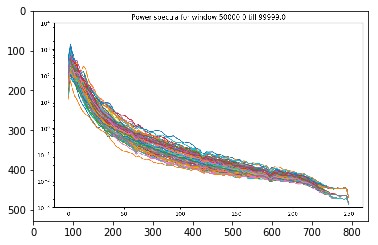

In [56]:
la = plt.imread('/home/emil/powSpecTest/cb46fd46_4/PowerSpec_cb46fd46_day4_bin_1.png')
plt.imshow(la)